In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import prince
import plotly.io as pio
import plotly.graph_objects as go
from itertools import combinations

## Análise de Correspondência Múltipla (MCA)

In [2]:
dados_mca = pd.read_excel("data/dados_cor_acm.xlsx")
# Fonte: adaptado de https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

In [3]:
dados_mca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   idade          918 non-null    int64 
 1   sexo           918 non-null    object
 2   dor.peito      918 non-null    object
 3   ps.descanco    918 non-null    int64 
 4   colesterol     918 non-null    int64 
 5   acucar.sangue  918 non-null    object
 6   ecg.descanco   918 non-null    object
 7   bc.max         918 non-null    int64 
 8   angina.exerc   918 non-null    object
 9   doenca.card    918 non-null    object
dtypes: int64(4), object(6)
memory usage: 71.8+ KB


- Algumas variáveis do banco de dados são métricas
- Um procedimento aplicável a elas é a categorização

*Serão categorizadas utilizando um critério quantitativo*

In [4]:
dados_mca['idade'] = pd.qcut(dados_mca['idade'], 3, labels=list(['menores_idades', 'idades_medias', 'maiores_idades']))
dados_mca['ps.descanco'] = pd.qcut(dados_mca['ps.descanco'], 3, labels=list(['ps_baixa', 'ps_media', 'ps_alta']))
dados_mca['colesterol'] = pd.qcut(dados_mca['colesterol'], 3, labels=list(['col_baixo', 'col_medio', 'col_alto']))
dados_mca['bc.max'] = pd.qcut(dados_mca['bc.max'], 3, labels=list(['bc_baixo', 'bc_medio', 'bc_alto']))

In [5]:
# Analisando as tabelas de contingência

# A seguir, a função extrai todas as tabelas de contingência possíveis

for item in list(combinations(dados_mca.columns, 2)):
    print(item, "\n")
    tabela = pd.crosstab(dados_mca[item[0]], dados_mca[item[1]])
    
    print(tabela)
    
    chi2, pvalor, gl, freq_esp = chi2_contingency(tabela)

    print(f"estatística qui²: {round(chi2, 2)}")
    print(f"p-valor da estatística: {round(pvalor, 4)}", "\n")

('idade', 'sexo') 

sexo            Feminino  Masculino
idade                              
menores_idades        78        238
idades_medias         62        252
maiores_idades        53        235
estatística qui²: 4.05
p-valor da estatística: 0.132 

('idade', 'dor.peito') 

dor.peito       Assintomatico  Atipica  Sem_Dor  Tipica
idade                                                  
menores_idades            142       86       74      14
idades_medias             169       67       70       8
maiores_idades            185       20       59      24
estatística qui²: 55.77
p-valor da estatística: 0.0 

('idade', 'ps.descanco') 

ps.descanco     ps_baixa  ps_media  ps_alta
idade                                      
menores_idades       153       115       48
idades_medias         92       157       65
maiores_idades        62       119      107
estatística qui²: 74.48
p-valor da estatística: 0.0 

('idade', 'colesterol') 

colesterol      col_baixo  col_medio  col_alto
idade       

**O MCA será parametrizado em 2 dimensões!**

In [6]:
# Elaborando a MCA

mca = prince.MCA(n_components=2).fit(dados_mca)

## Quantidade total de dimensões

### Quantidade de dimensões = qtde total de categorias - qtde de variáveis

In [7]:
# Quantidade total de categorias
mca.J_

# Quantidade de variáveis na análise
mca.K_

# Quantidade de dimensões
quant_dim = mca.J_ - mca.K_

# Resumo das informações
print(f"quantidade total de categorias: {mca.J_}")
print(f"quantidade de variáveis: {mca.K_}")
print(f"quantidade de dimensões: {quant_dim}")

quantidade total de categorias: 27
quantidade de variáveis: 10
quantidade de dimensões: 17


In [8]:
# Obtendo os eigenvalues

tabela_autovalores = mca.eigenvalues_summary

print(tabela_autovalores)

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.285        16.78%                     16.78%
1              0.138         8.14%                     24.92%


### Inércia principal total

In [9]:
# Soma de todos os autovalores (todas as dimensões existentes)

print(mca.total_inertia_)

1.6999999999999933


In [10]:
# Obtendo as coordenadas principais das categorias das variáveis

coord_burt = mca.column_coordinates(dados_mca)

print(coord_burt)

                                    0         1
idade_menores_idades         0.632520 -0.537190
idade_idades_medias         -0.064234  0.000510
idade_maiores_idades        -0.623982  0.588861
sexo_Feminino                0.817785  0.574861
sexo_Masculino              -0.217700 -0.153032
dor.peito_Assintomatico     -0.603308 -0.124550
dor.peito_Atipica            1.111319 -0.167829
dor.peito_Sem_Dor            0.460685  0.120650
dor.peito_Tipica             0.292687  1.441725
ps.descanco_ps_baixa         0.321364 -0.647289
ps.descanco_ps_media         0.032316  0.143296
ps.descanco_ps_alta         -0.505884  0.648587
colesterol_col_baixo        -0.401161 -0.535652
colesterol_col_medio         0.326836 -0.116793
colesterol_col_alto          0.080658  0.659087
acucar.sangue_Diabetes      -0.693981  0.098700
acucar.sangue_Normal         0.210954 -0.030003
ecg.descanco_Anormal_ST     -0.566819 -0.002742
ecg.descanco_Hipertrofia_VE  0.034275  1.251132
ecg.descanco_Normal          0.171105 -0

In [11]:
# Obtendo as coordenadas-padrão das categorias das variáveis

coord_padrao = mca.column_coordinates(dados_mca)/np.sqrt(mca.eigenvalues_)

print(coord_padrao)

                                    0         1
idade_menores_idades         1.184301 -1.443833
idade_idades_medias         -0.120269  0.001371
idade_maiores_idades        -1.168314  1.582711
sexo_Feminino                1.531181  1.545083
sexo_Masculino              -0.407611 -0.411312
dor.peito_Assintomatico     -1.129606 -0.334759
dor.peito_Atipica            2.080781 -0.451083
dor.peito_Sem_Dor            0.862565  0.324276
dor.peito_Tipica             0.548013  3.874998
ps.descanco_ps_baixa         0.601706 -1.739752
ps.descanco_ps_media         0.060508  0.385143
ps.descanco_ps_alta         -0.947192  1.743239
colesterol_col_baixo        -0.751115 -1.439698
colesterol_col_medio         0.611952 -0.313910
colesterol_col_alto          0.151019  1.771461
acucar.sangue_Diabetes      -1.299377  0.265281
acucar.sangue_Normal         0.394981 -0.080639
ecg.descanco_Anormal_ST     -1.061285 -0.007370
ecg.descanco_Hipertrofia_VE  0.064175  3.362731
ecg.descanco_Normal          0.320369 -1

In [12]:
# Obtendo as coordenadas das observações do banco de dados

# Na função, as coordenadas das observações vêm das coordenadas-padrão

coord_obs = mca.row_coordinates(dados_mca)

print(coord_obs)

            0         1
0    0.815386 -0.038115
1    0.398071  0.015224
2    0.368483 -0.045417
3   -0.128005 -0.211495
4    0.063386 -0.122220
..        ...       ...
913  0.243901  0.058253
914 -0.573661  0.001707
915 -0.588648 -0.375193
916  0.600893  0.509541
917  0.603350 -0.281695

[918 rows x 2 columns]


In [13]:
# Plotando o mapa perceptual (coordenadas-padrão)

# Primeiro passo: gerar um DataFrame detalhado

chart = coord_padrao.reset_index()

nome_categ=[]
for col in dados_mca:
    nome_categ.append(dados_mca[col].sort_values(ascending=True).unique())
    categorias = pd.DataFrame(nome_categ).stack().reset_index()

var_chart = pd.Series(chart['index'].str.split('_', expand=True).iloc[:,0])

chart_df_mca = pd.DataFrame({'categoria': chart['index'],
                             'obs_x': chart[0],
                             'obs_y': chart[1],
                             'variavel': var_chart,
                             'categoria_id': categorias[0]})

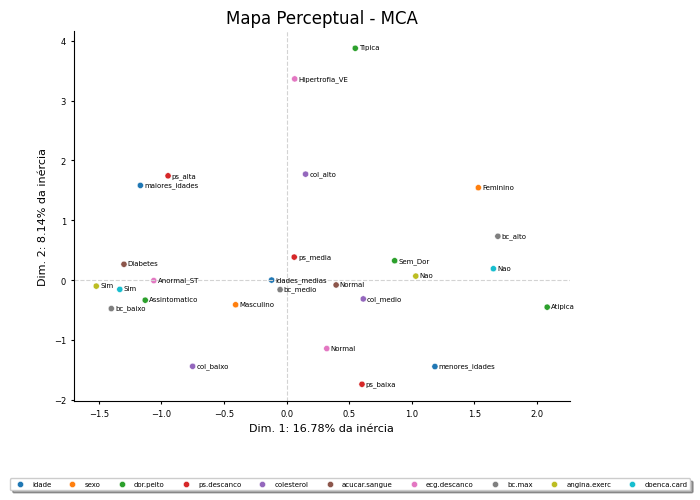

In [14]:
# Segundo passo: gerar o gráfico de pontos
    
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + 0.03, point['y'] - 0.02, point['val'], fontsize=5)

label_point(x = chart_df_mca['obs_x'],
            y = chart_df_mca['obs_y'],
            val = chart_df_mca['categoria_id'],
            ax = plt.gca())

sns.scatterplot(data=chart_df_mca, x='obs_x', y='obs_y', hue='variavel', s=20)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.axhline(y=0, color='lightgrey', ls='--', linewidth=0.8)
plt.axvline(x=0, color='lightgrey', ls='--', linewidth=0.8)
plt.tick_params(size=2, labelsize=6)
plt.legend(bbox_to_anchor=(1.25,-0.2), fancybox=True, shadow=True, ncols=10, fontsize='5')
plt.title("Mapa Perceptual - MCA", fontsize=12)
plt.xlabel(f"Dim. 1: {tabela_autovalores.iloc[0,1]} da inércia", fontsize=8)
plt.ylabel(f"Dim. 2: {tabela_autovalores.iloc[1,1]} da inércia", fontsize=8)
plt.show()

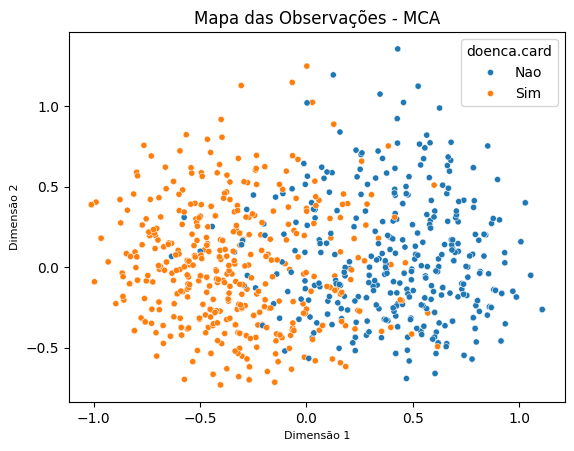

In [15]:
# Gráfico das observações

coord_obs['doenca.card'] = dados_mca['doenca.card']

sns.scatterplot(data=coord_obs, x=0, y=1, hue='doenca.card', s=20)
plt.title("Mapa das Observações - MCA", fontsize=12)
plt.xlabel("Dimensão 1", fontsize=8)
plt.ylabel("Dimensão 2", fontsize=8)
plt.show()